## Load Tensorboard

In [1]:
%load_ext tensorboard

## Import Libraries

In [2]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

## Initialize Tensorflow

In [3]:
from tensorflow.keras import backend as K
K.clear_session()

## Load Data

In [4]:
data = pd.read_csv("../labels.csv")
imgs = ["{}.jpg".format(x) for x in list(data.id)]
img_label = list(data['breed'])

# Split data into train and validation set equally
b_sp = StratifiedShuffleSplit(1, 0.1)
imgs = np.array(imgs)
img_label = np.array(img_label)
for train_idx, val_idx in b_sp.split(imgs, img_label):
    train_x = imgs[train_idx]
    train_y = img_label[train_idx]
    val_x = imgs[val_idx]
    val_y = img_label[val_idx]

train_y = train_y.astype(str)
val_y = val_y.astype(str)
train_data = pd.DataFrame({'id': train_x,'breed': train_y})
val_data = pd.DataFrame({'id': val_x,'breed': val_y})

In [5]:
BATCH_SIZE = 256

# Number of epochs for training
EPOCHS = 100

# The original image will be resized to the size specified below.
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Path to image for training
#TRAIN_PATH = '../img/train/'
TRAIN_PATH = '../img/train/'
TEST_PATH = '../img/test/'

In [6]:
b_sp = StratifiedShuffleSplit(1, 0.1)
imgs = np.array(imgs)
img_label = np.array(img_label)
for train_idx, val_idx in b_sp.split(imgs, img_label):
    train_x = imgs[train_idx]
    train_y = img_label[train_idx]
    val_x = imgs[val_idx]
    val_y = img_label[val_idx]
    
train_data = pd.DataFrame({'id': train_x,'breed': train_y})
val_data = pd.DataFrame({'id': val_x,'breed': val_y})

## Preprocess Image

In [7]:
# For train image generator, more params may be added to generate augmented image.
train_image_generator = ImageDataGenerator(rescale=1./255)
val_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen = train_image_generator.flow_from_dataframe(
                                        dataframe = train_data,
                                        directory=TRAIN_PATH,x_col="id",
                                        y_col="breed",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT,IMG_WIDTH),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)
val_data_gen = val_image_generator.flow_from_dataframe(
                                        dataframe = val_data,
                                        directory=TRAIN_PATH,x_col="id",
                                        y_col="breed",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT,IMG_WIDTH),
                                        batch_size=BATCH_SIZE)

Found 9199 validated image filenames belonging to 120 classes.
Found 1023 validated image filenames belonging to 120 classes.


In [9]:
# For checking of class distribution in train and validation set
# If unused, leave this commented to reduce output on your screen.

# breedcnt = dict()
# breedcntval = dict()
# for i in train_data['breed']:
#     try:
#         breedcnt[i] += 1
#     except:
#         breedcnt[i] = 1
        
# for i in val_data['breed']:
#     try:
#         breedcntval[i] += 1
#     except:
#         breedcntval[i] = 1
        
# for i in breedcnt.keys():
#     print(i, " : ", breedcnt[i], " | ", breedcntval[i])

## Define Model

In [10]:
# Define you model here
# The model provided is just placeholder
# Do not modify the input shape and the output layer
def get_base_model():
    input1 = Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
    x = Conv2D(32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))(input1)
    x = Conv2D(32, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, kernel_size=3, activation='relu')(x)
    x = Conv2D(128, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, kernel_size=3, activation='relu')(x)
    x = Conv2D(256, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(512, kernel_size=3, activation='relu')(x)
    x = Conv2D(512, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(120, activation='softmax')(x)
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['categorical_crossentropy','categorical_accuracy','accuracy'])
    
    return model

In [11]:
base_model = get_base_model()

In [12]:
# Total parmas should not exceed 120M or the VM may crash
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0     

## Train the model

In [17]:
# Path to save model parameters
weight_path_model_base ='model_custom2_fc.h5'
# Path to write tensorboard
tensorboard_path_model_base = 'Graphs/pattern_nn_custom2_fc'

callbacks_list_model_base = [
    TensorBoard(log_dir=tensorboard_path_model_base, histogram_freq=1, write_graph=True, write_grads=True),
    ModelCheckpoint(
            weight_path_model_base,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0000001),
    EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=16,
        mode='min',
        restore_best_weights=True)

]

history_base = base_model.fit_generator(train_data_gen, epochs=EPOCHS, verbose=1, validation_data=val_data_gen,
                                        callbacks=callbacks_list_model_base)

Epoch 1/100
35/36 [============================>.] - ETA: 1s - loss: 4.7866 - categorical_crossentropy: 4.7866 - categorical_accuracy: 0.0089 - accuracy: 0.0089
Epoch 00001: val_loss improved from inf to 4.77985, saving model to model_custom2_fc.h5
36/36 [==============================] - 55s 2s/step - loss: 4.7865 - categorical_crossentropy: 4.7865 - categorical_accuracy: 0.0090 - accuracy: 0.0090 - val_loss: 4.7798 - val_categorical_crossentropy: 4.7798 - val_categorical_accuracy: 0.0127 - val_accuracy: 0.0127
Epoch 2/100
35/36 [============================>.] - ETA: 1s - loss: 4.7819 - categorical_crossentropy: 4.7819 - categorical_accuracy: 0.0105 - accuracy: 0.0105
Epoch 00002: val_loss improved from 4.77985 to 4.77834, saving model to model_custom2_fc.h5
36/36 [==============================] - 48s 1s/step - loss: 4.7817 - categorical_crossentropy: 4.7817 - categorical_accuracy: 0.0109 - accuracy: 0.0109 - val_loss: 4.7783 - val_categorical_crossentropy: 4.7783 - val_categorical_

35/36 [============================>.] - ETA: 1s - loss: 4.7770 - categorical_crossentropy: 4.7770 - categorical_accuracy: 0.0130 - accuracy: 0.0130
Epoch 00017: val_loss did not improve from 4.77496
36/36 [==============================] - 50s 1s/step - loss: 4.7765 - categorical_crossentropy: 4.7765 - categorical_accuracy: 0.0127 - accuracy: 0.0127 - val_loss: 4.7750 - val_categorical_crossentropy: 4.7750 - val_categorical_accuracy: 0.0127 - val_accuracy: 0.0127
Epoch 18/100
35/36 [============================>.] - ETA: 1s - loss: 4.7758 - categorical_crossentropy: 4.7759 - categorical_accuracy: 0.0117 - accuracy: 0.0117
Epoch 00018: val_loss did not improve from 4.77496
36/36 [==============================] - 49s 1s/step - loss: 4.7759 - categorical_crossentropy: 4.7760 - categorical_accuracy: 0.0120 - accuracy: 0.0120 - val_loss: 4.7750 - val_categorical_crossentropy: 4.7750 - val_categorical_accuracy: 0.0127 - val_accuracy: 0.0127
Epoch 19/100
35/36 [============================>

Epoch 34/100
35/36 [============================>.] - ETA: 1s - loss: 4.7763 - categorical_crossentropy: 4.7763 - categorical_accuracy: 0.0125 - accuracy: 0.0125
Epoch 00034: val_loss did not improve from 4.77496
36/36 [==============================] - 50s 1s/step - loss: 4.7762 - categorical_crossentropy: 4.7762 - categorical_accuracy: 0.0123 - accuracy: 0.0123 - val_loss: 4.7750 - val_categorical_crossentropy: 4.7750 - val_categorical_accuracy: 0.0127 - val_accuracy: 0.0127
Epoch 35/100
35/36 [============================>.] - ETA: 1s - loss: 4.7763 - categorical_crossentropy: 4.7763 - categorical_accuracy: 0.0126 - accuracy: 0.0126
Epoch 00035: val_loss did not improve from 4.77496
36/36 [==============================] - 49s 1s/step - loss: 4.7763 - categorical_crossentropy: 4.7763 - categorical_accuracy: 0.0124 - accuracy: 0.0124 - val_loss: 4.7750 - val_categorical_crossentropy: 4.7750 - val_categorical_accuracy: 0.0127 - val_accuracy: 0.0127
Epoch 36/100
35/36 [================

## Train Logs

In [14]:
# What is tracked
print(history_base.history.keys())

dict_keys(['loss', 'categorical_crossentropy', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy', 'val_accuracy', 'lr'])


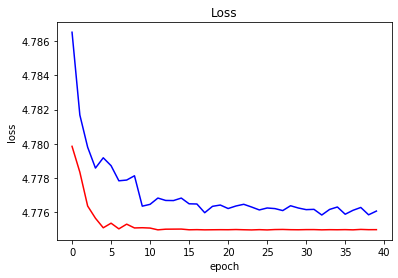

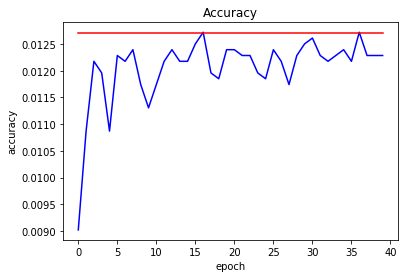

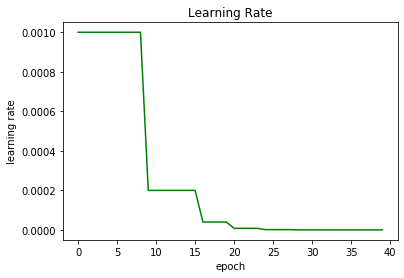

In [18]:
train_loss = history_base.history['loss']
train_acc = history_base.history['accuracy']
val_loss = history_base.history['val_loss']
val_acc = history_base.history['val_accuracy']
learnrate = history_base.history['lr']

plt.plot(train_loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(train_acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(learnrate, color='green')
plt.title('Learning Rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

## Load class details

In [22]:
classes = train_data_gen.class_indices

In [20]:
inverted_classes = dict(map(reversed, classes.items()))

In [26]:
class_list = [i for i in classes.keys()]

## Load test data

In [23]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TEST_PATH,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=None)

Found 10357 images belonging to 1 classes.


## Run on test data

In [24]:
test_result = base_model.predict_generator(test_data_gen, verbose=1)

41/41 [==============================] - 49s 1s/step


## Prepare data for csv

In [27]:
filenames = [i[i.find('/')+1:i.rfind('.')] for i in test_data_gen.filenames]
filenames_arr = np.array(filenames)[np.newaxis].T
test_result_with_label = np.concatenate((filenames_arr, test_result), axis=1)
csv_header = ['id'] + class_list

## Export data to csv

In [28]:
# Be aware that the file with the same name should not exist, or it will be overwrited.
result_dataframe = pd.DataFrame(test_result_with_label, columns=csv_header)
result_dataframe.to_csv('./result_custom2_fc.csv', index=False)

In [15]:
from tensorflow.keras.applications import VGG19

vgg19 = VGG19(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 6s 0us/step


In [16]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     